In [1]:
# Part 1 (a)
for line in open('SMSSpamCollection'):
    if line[0] == 's':
        print(line)
        break

for line in open('SMSSpamCollection'):
    if line[0] == 'h':
        print(line)
        break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



In [2]:
# Part 1 (b)
num_spam = 0
for line in open('SMSSpamCollection'):
    if line[0] == 's':
        num_spam += 1
print(num_spam)

num_non = 0
for line in open('SMSSpamCollection'):
    if line[0] == 'h':
        num_non += 1
print(num_non)

747
4827


In [3]:
# Part 1 (c)
# Advantage: RNN will also learn specific names
# Disadvantage: computing power and time are spent learning words instead of
# how words are connected (often more important)

In [4]:
# Part 1 (d)
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)
# dataset[0].sms
# dataset[0].label

train, valid, test= dataset.split(split_ratio = [0.6,0.2,0.2],
                                  stratified = True, strata_field = 'label')

In [5]:
len(train)

3343

In [6]:
len(valid)

1115

In [7]:
len(test)

1114

In [8]:
# Part 1 (e)
# A balanced training set will not lead to overfitting to the most popular
# label. For example, if a dataset contains 90% label A, just by outputing A,
# a model can get 90% accuracy.

# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In [9]:
# Part 1 (f)
# text_field.vocab.stoi is a string-to-integer dictionary of existing
# characters to their assigned integer values.
# text_field.vocab.itos is an integer-to-string dictionary-like list of
# integer values (represented by the index position) to their characters.

text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

In [11]:
text_field.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index()>,
            {'<unk>': 0,
             '<pad>': 1,
             ' ': 2,
             'e': 3,
             'o': 4,
             't': 5,
             'a': 6,
             'n': 7,
             'r': 8,
             'i': 9,
             's': 10,
             'l': 11,
             'u': 12,
             'h': 13,
             '0': 14,
             'd': 15,
             'c': 16,
             '.': 17,
             'm': 18,
             'y': 19,
             'w': 20,
             'p': 21,
             'g': 22,
             '1': 23,
             'f': 24,
             'b': 25,
             '2': 26,
             'T': 27,
             '8': 28,
             'E': 29,
             'k': 30,
             'v': 31,
             '5': 32,
             'S': 33,
             'C': 34,
             'O': 35,
             'I': 36,
             '4': 37,
             'N': 38,
             'A': 39,
             'x': 40,
             '7': 41,
             '6':

In [10]:
# Part 1 (g)
# <unk> represents an unknown, rare word. Used when dealing at word-level.
# <pad> is padding used to make batches of equal length.

In [33]:
# Part 1 (h)

train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                   # repeat the iterator for multiple epochs

num_pad = []

print('Max length in each batch is the following:')
for i, batch in enumerate(train_iter):
    if i >= 10:
        break
    
    print(batch.sms[1][0].item())
    
    num_pad_batch = 0
    for j in batch.sms[0]:
        for k in j:
            if k.item() == 1:
                num_pad_batch += 1
    num_pad.append(num_pad_batch)

print('The number of <pad>s in each batch is the following:')
print(num_pad)

Max length in each batch is the following:
93
28
160
36
138
146
148
161
41
158
The number of <pad>s in each batch is the following:
[76, 27, 0, 20, 19, 30, 13, 20, 27, 0]


In [13]:
# Part 2
import torch
import numpy

# You mind find this code helpful for obtaining
# pytorch one-hot vectors.

ident = torch.eye(10, dtype = torch.float32)
#ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [14]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.emb = nn.Embedding(len(text_field.vocab.stoi), hidden_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        #out = self.fc(out[:, -1, :])
        out = self.fc(torch.max(out, dim=1)[0])
        return out

# This code is here to help you test your model.
# You may beed to change this depending on how your forward
# function is set up.

model = RNN(10, 10, 2)
sample_batch = next(iter(train_iter))
sms = sample_batch.sms[0]
length = sample_batch.sms[1]
y = model(sms)
print(y.shape)

torch.Size([32, 2])


In [28]:
# Part 3 (a)
import matplotlib.pyplot as plt
%matplotlib inline

def get_accuracy(model, data):
    data_iter = torchtext.data.BucketIterator(data, 
                                              batch_size=64, 
                                              sort_key=lambda x: len(x.sms), 
                                              repeat=False)
    correct, total = 0, 0
    for i, batch in enumerate(data_iter):
        output = model(batch.sms[0]) # You may need to modify this, depending on your model setup
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += batch.sms[1].shape[0]
    return correct / total

def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5, batch_size=32):
    train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                   # repeat the iterator for multiple epochs
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc, loss = [], [], [], 0
    epochs = []
    for epoch in range(num_epochs):
        print(epoch)
        for j, batch in enumerate(train_iter):
            l = batch.label
            s = batch.sms
        
            optimizer.zero_grad()
            pred = model(s[0])
            loss = criterion(pred, l)
            
            loss.backward()
            optimizer.step()
    
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(RNN(10, 10, 2), train))
        valid_acc.append(get_accuracy(RNN(10, 10, 2), valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
            epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

0
Epoch 1; Loss 0.763615; Train Acc 0.480020; Val Acc 0.862780
1
Epoch 2; Loss 0.633558; Train Acc 0.520478; Val Acc 0.864574
2
Epoch 3; Loss 0.606716; Train Acc 0.522799; Val Acc 0.865471
3
Epoch 4; Loss 0.794142; Train Acc 0.519980; Val Acc 0.134529
4
Epoch 5; Loss 0.615960; Train Acc 0.479688; Val Acc 0.141704


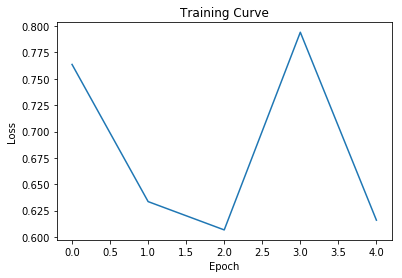

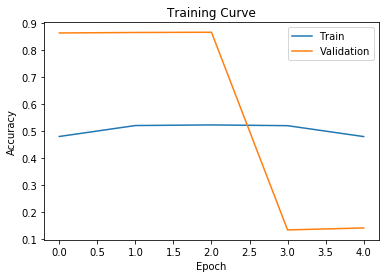

In [16]:
train_rnn_network(RNN(10, 10, 2), train_iter, valid, num_epochs=5,
                  learning_rate=1e-5)

0
Epoch 1; Loss 0.888866; Train Acc 0.480020; Val Acc 0.135426
1
Epoch 2; Loss 1.250517; Train Acc 0.520478; Val Acc 0.134529
2
Epoch 3; Loss 1.236499; Train Acc 0.519980; Val Acc 0.863677
3
Epoch 4; Loss 0.345989; Train Acc 0.416846; Val Acc 0.547085
4
Epoch 5; Loss 0.599730; Train Acc 0.519980; Val Acc 0.865471
5
Epoch 6; Loss 1.205293; Train Acc 0.521472; Val Acc 0.134529
6
Epoch 7; Loss 0.452605; Train Acc 0.480020; Val Acc 0.134529
7
Epoch 8; Loss 1.155143; Train Acc 0.519980; Val Acc 0.865471
8
Epoch 9; Loss 0.343446; Train Acc 0.519980; Val Acc 0.134529
9
Epoch 10; Loss 0.410172; Train Acc 0.480020; Val Acc 0.865471
10
Epoch 11; Loss 0.595016; Train Acc 0.519980; Val Acc 0.865471
11
Epoch 12; Loss 0.995447; Train Acc 0.519980; Val Acc 0.865471
12
Epoch 13; Loss 0.451761; Train Acc 0.519980; Val Acc 0.134529
13
Epoch 14; Loss 1.029853; Train Acc 0.480020; Val Acc 0.134529
14
Epoch 15; Loss 0.591017; Train Acc 0.480020; Val Acc 0.134529
15
Epoch 16; Loss 1.046984; Train Acc 0.5929

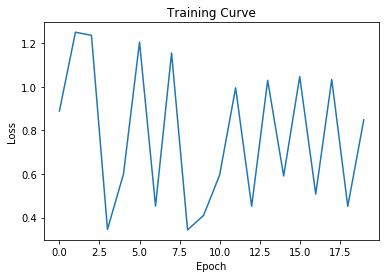

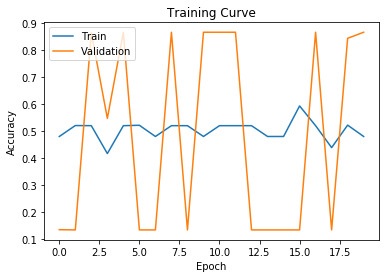

In [24]:
# Part 3 (b)
# Trial #1
# Previous num_epochs is 5. Could not see the overall trend well.
# Increased num_epochs to 20
# Valid acc is 85% (with consistency problems)

train_rnn_network(RNN(10, 10, 2), train_iter, valid, num_epochs=20,
                  learning_rate=1e-5)

0
Epoch 1; Loss 0.769215; Train Acc 0.524623; Val Acc 0.134529
1
Epoch 2; Loss 0.726124; Train Acc 0.379373; Val Acc 0.865471
2
Epoch 3; Loss 0.608583; Train Acc 0.480020; Val Acc 0.795516
3
Epoch 4; Loss 0.617511; Train Acc 0.586470; Val Acc 0.134529
4
Epoch 5; Loss 0.819547; Train Acc 0.480849; Val Acc 0.135426
5
Epoch 6; Loss 0.628893; Train Acc 0.519980; Val Acc 0.134529
6
Epoch 7; Loss 0.621459; Train Acc 0.519980; Val Acc 0.834978
7
Epoch 8; Loss 0.773693; Train Acc 0.413198; Val Acc 0.818834
8
Epoch 9; Loss 0.606781; Train Acc 0.480020; Val Acc 0.134529
9
Epoch 10; Loss 0.627239; Train Acc 0.520146; Val Acc 0.134529
10
Epoch 11; Loss 0.651540; Train Acc 0.480020; Val Acc 0.856502
11
Epoch 12; Loss 0.784925; Train Acc 0.520975; Val Acc 0.134529
12
Epoch 13; Loss 0.667630; Train Acc 0.471398; Val Acc 0.134529
13
Epoch 14; Loss 0.615776; Train Acc 0.480020; Val Acc 0.865471
14
Epoch 15; Loss 0.800693; Train Acc 0.479854; Val Acc 0.865471
15
Epoch 16; Loss 0.618387; Train Acc 0.4800

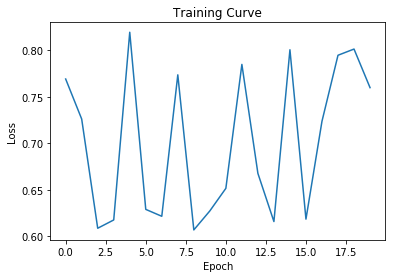

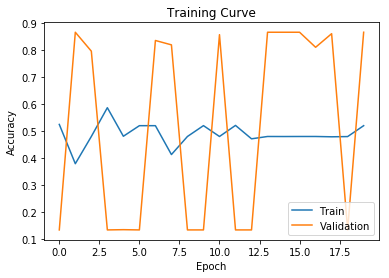

In [25]:
# Trial #2
# Previous loss and valid plots very jittery, thought decreasing learning_rate
# would stablized. It did not.
# Decreased learning_rate to 1e-6
# Valid acc is still 85% (with consistency problems)

train_rnn_network(RNN(10, 10, 2), train_iter, valid, num_epochs=20,
                  learning_rate=1e-6)

0
Epoch 1; Loss 0.641894; Train Acc 0.521970; Val Acc 0.478908
1
Epoch 2; Loss 0.666710; Train Acc 0.479854; Val Acc 0.477916
2
Epoch 3; Loss 0.822245; Train Acc 0.480020; Val Acc 0.478908
3
Epoch 4; Loss 0.808926; Train Acc 0.480020; Val Acc 0.521092
4
Epoch 5; Loss 0.828313; Train Acc 0.519980; Val Acc 0.500744
5
Epoch 6; Loss 0.817445; Train Acc 0.480020; Val Acc 0.524069
6
Epoch 7; Loss 0.702273; Train Acc 0.519980; Val Acc 0.522084
7
Epoch 8; Loss 0.808636; Train Acc 0.529100; Val Acc 0.521092
8
Epoch 9; Loss 0.649615; Train Acc 0.480020; Val Acc 0.521092
9
Epoch 10; Loss 0.648863; Train Acc 0.480020; Val Acc 0.478908
10
Epoch 11; Loss 0.848926; Train Acc 0.514508; Val Acc 0.533995
11
Epoch 12; Loss 0.842385; Train Acc 0.519980; Val Acc 0.522084
12
Epoch 13; Loss 0.854700; Train Acc 0.479688; Val Acc 0.478908
13
Epoch 14; Loss 0.829356; Train Acc 0.480020; Val Acc 0.478908
14
Epoch 15; Loss 0.695435; Train Acc 0.480020; Val Acc 0.478412
15
Epoch 16; Loss 0.793028; Train Acc 0.4803

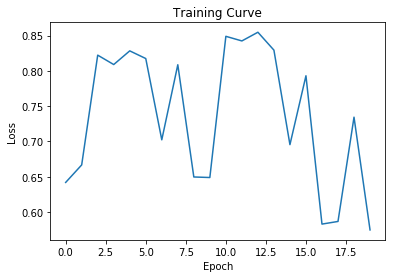

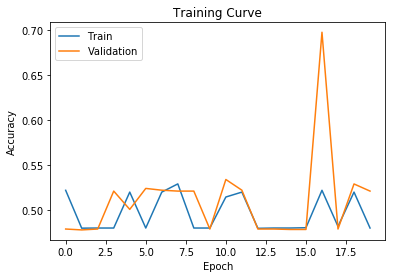

In [26]:
# Trial #3
# Thought a model trained with a balanced dataset would not do well during
# validation with an imbalanced dataset.
# Duplicated spam in valid dataset by a factor of 6 also
# Valid acc is 70% at peek

old_valid_examples = valid.examples
valid_spam = []
for item in valid.examples:
    if item.label == 1:
        valid_spam.append(item)

valid.examples = old_valid_examples + valid_spam * 6

train_rnn_network(RNN(10, 10, 2), train_iter, valid, num_epochs=20,
                  learning_rate=1e-6)

0
Epoch 1; Loss 0.506941; Train Acc 0.480020; Val Acc 0.521092
1
Epoch 2; Loss 0.919603; Train Acc 0.519980; Val Acc 0.522084
2
Epoch 3; Loss 0.732741; Train Acc 0.480020; Val Acc 0.478908
3
Epoch 4; Loss 0.904622; Train Acc 0.520312; Val Acc 0.526551
4
Epoch 5; Loss 0.847900; Train Acc 0.519980; Val Acc 0.478412
5
Epoch 6; Loss 0.787778; Train Acc 0.478528; Val Acc 0.623821
6
Epoch 7; Loss 0.516550; Train Acc 0.476538; Val Acc 0.521092
7
Epoch 8; Loss 0.877684; Train Acc 0.480020; Val Acc 0.475931
8
Epoch 9; Loss 0.847396; Train Acc 0.520643; Val Acc 0.390074
9
Epoch 10; Loss 0.512623; Train Acc 0.480020; Val Acc 0.521092
10
Epoch 11; Loss 0.835399; Train Acc 0.523130; Val Acc 0.475931
11
Epoch 12; Loss 0.562757; Train Acc 0.661416; Val Acc 0.478908
12
Epoch 13; Loss 0.667825; Train Acc 0.702703; Val Acc 0.478412
13
Epoch 14; Loss 0.677824; Train Acc 0.519980; Val Acc 0.478908
14
Epoch 15; Loss 0.712267; Train Acc 0.519980; Val Acc 0.474938
15
Epoch 16; Loss 0.906640; Train Acc 0.5199

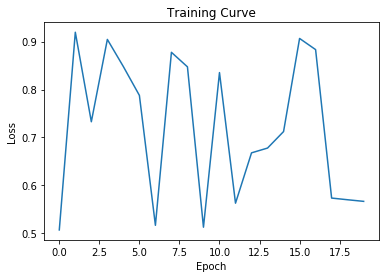

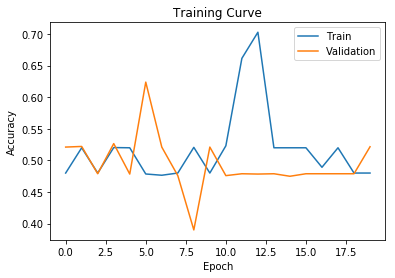

In [29]:
# Trial #4
# Thought previous plot was too stable, decreasing batch_size may bring more
# improvement.
# Decreased batch_size to 8
# Valid acc is 63% at peek

train_rnn_network(RNN(10, 10, 2), train, valid, num_epochs=20,
                  learning_rate=1e-6, batch_size=8)

0
Epoch 1; Loss 0.515827; Train Acc 0.519980; Val Acc 0.521092
1
Epoch 2; Loss 0.877051; Train Acc 0.519980; Val Acc 0.478908
2
Epoch 3; Loss 0.705355; Train Acc 0.519980; Val Acc 0.478908
3
Epoch 4; Loss 0.872909; Train Acc 0.480020; Val Acc 0.521092
4
Epoch 5; Loss 0.811247; Train Acc 0.583320; Val Acc 0.478908
5
Epoch 6; Loss 0.788810; Train Acc 0.480020; Val Acc 0.521092
6
Epoch 7; Loss 0.527461; Train Acc 0.480020; Val Acc 0.478908
7
Epoch 8; Loss 0.865794; Train Acc 0.520643; Val Acc 0.521092
8
Epoch 9; Loss 0.815014; Train Acc 0.521141; Val Acc 0.521092
9
Epoch 10; Loss 0.537031; Train Acc 0.570552; Val Acc 0.478908
10
Epoch 11; Loss 0.775206; Train Acc 0.369093; Val Acc 0.468486
11
Epoch 12; Loss 0.580069; Train Acc 0.480020; Val Acc 0.474938
12
Epoch 13; Loss 0.656616; Train Acc 0.519980; Val Acc 0.530521
13
Epoch 14; Loss 0.658153; Train Acc 0.478030; Val Acc 0.478908
14
Epoch 15; Loss 0.701381; Train Acc 0.480020; Val Acc 0.478908
15
Epoch 16; Loss 0.805945; Train Acc 0.5199

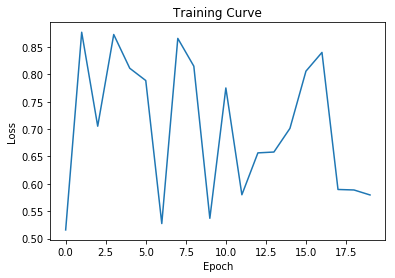

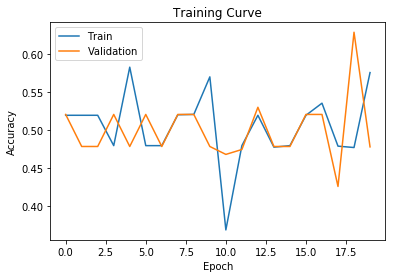

In [30]:
# Trial #5
# Previous hyper-parameters ran reasonably quick, thought increasing layer
# sizes could improve accuracy.
# Increased input and hidden layer sizes to 20
# Valid acc is 63% at peek

train_rnn_network(RNN(20, 20, 2), train, valid, num_epochs=20,
                  learning_rate=1e-6, batch_size=8)

0
Epoch 1; Loss 1.076035; Train Acc 0.519980; Val Acc 0.351861
1
Epoch 2; Loss 0.466367; Train Acc 0.519980; Val Acc 0.477916
2
Epoch 3; Loss 0.728957; Train Acc 0.474714; Val Acc 0.521588
3
Epoch 4; Loss 1.140865; Train Acc 0.479191; Val Acc 0.478908
4
Epoch 5; Loss 1.068177; Train Acc 0.479357; Val Acc 0.521588
5
Epoch 6; Loss 0.556215; Train Acc 0.480020; Val Acc 0.478908
6
Epoch 7; Loss 1.067514; Train Acc 0.519980; Val Acc 0.521092
7
Epoch 8; Loss 1.164998; Train Acc 0.478196; Val Acc 0.478908
8
Epoch 9; Loss 0.553509; Train Acc 0.519980; Val Acc 0.521092
9
Epoch 10; Loss 0.433946; Train Acc 0.476870; Val Acc 0.521092
10
Epoch 11; Loss 1.127679; Train Acc 0.480020; Val Acc 0.521092
11
Epoch 12; Loss 0.953405; Train Acc 0.682806; Val Acc 0.478908
12
Epoch 13; Loss 0.971642; Train Acc 0.480020; Val Acc 0.478908
13
Epoch 14; Loss 0.424787; Train Acc 0.480020; Val Acc 0.467990
14
Epoch 15; Loss 0.424081; Train Acc 0.621290; Val Acc 0.521092
15
Epoch 16; Loss 0.958184; Train Acc 0.4800

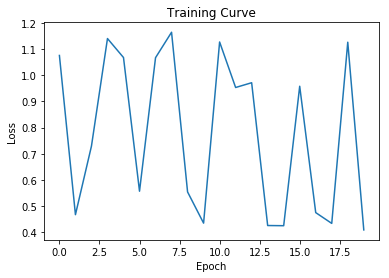

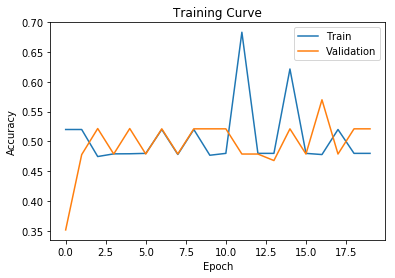

In [31]:
# Trial #6
# Previous plots' shapes too unorthodox, thought increasing batch_size would
# bring more stability and more traditional plot shape.
# Increased batch_size to 256
# Valid acc is 58% at peek

train_rnn_network(RNN(20, 20, 2), train, valid, num_epochs=20,
                  learning_rate=1e-6, batch_size=256)

0
Epoch 1; Loss 0.949650; Train Acc 0.519980; Val Acc 0.521092
1
Epoch 2; Loss 0.697485; Train Acc 0.480020; Val Acc 0.455583
2
Epoch 3; Loss 0.922858; Train Acc 0.519980; Val Acc 0.478908
3
Epoch 4; Loss 0.469681; Train Acc 0.480020; Val Acc 0.521092
4
Epoch 5; Loss 0.951101; Train Acc 0.519980; Val Acc 0.521092
5
Epoch 6; Loss 0.696137; Train Acc 0.480020; Val Acc 0.452109
6
Epoch 7; Loss 0.697391; Train Acc 0.523628; Val Acc 0.478908
7
Epoch 8; Loss 0.694923; Train Acc 0.519980; Val Acc 0.531514
8
Epoch 9; Loss 0.951492; Train Acc 0.519980; Val Acc 0.521092
9
Epoch 10; Loss 0.921834; Train Acc 0.480020; Val Acc 0.478908
10
Epoch 11; Loss 0.981023; Train Acc 0.471895; Val Acc 0.521092
11
Epoch 12; Loss 0.922342; Train Acc 0.519980; Val Acc 0.478908
12
Epoch 13; Loss 0.470069; Train Acc 0.521141; Val Acc 0.472953
13
Epoch 14; Loss 0.695546; Train Acc 0.519980; Val Acc 0.418362
14
Epoch 15; Loss 0.980040; Train Acc 0.524125; Val Acc 0.521092
15
Epoch 16; Loss 0.922818; Train Acc 0.4800

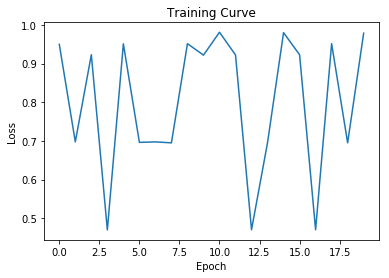

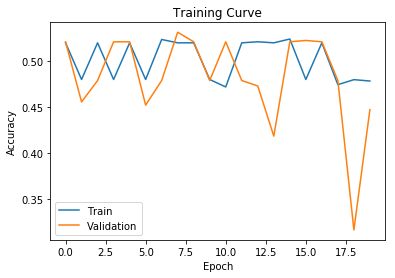

In [32]:
# Trial #7
# Previous change worked somewhat well, thought further increasing the
# batch_size would improve result like last time. It did not work.
# Increased batch_size to 1024
# Valid acc is 53% at peek

train_rnn_network(RNN(20, 20, 2), train, valid, num_epochs=20,
                  learning_rate=1e-6, batch_size=1024)

In [ ]:
# Part 3 (c)
# Best result is trial #5. Valid acc is 63% with decent overall shape.
# More complex model likely will help accuracy. Current one quite simple.

In [ ]:
# Part 4
# Not too difficult task.
# A baseline model could be a word-level RNN looking for keywords to detect spam.
# In my experience, spam emails are not written creatively. Thus, detecting
# a few keywords, such as "free", "lottery", "gift", "trial", is likely to
# give a decent result.